This notebook aims at giving a very short introduction to markov random fields by implementing the first example given in 
[this excelent webpage on MRF](https://ermongroup.github.io/cs228-notes/representation/undirected/)

This first code part is not important: 
We import some packages and define some some utility stuff. 

In [1]:
from dataclasses import dataclass
from itertools import product

import numpy as np
from matplotlib import pyplot as plt

import networkx as nx


@dataclass(frozen=True)
class NodeWithPos:
    value: float
    _posx: int
    _posy: int

    def pos(self):
        return self._posx, self._posy

def draw_graph(graph: nx.Graph, title='', ax=None):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    if title:
        ax.set_title(title, color='w')
    nodelist = graph.nodes
    posdict = dict([(node, node.pos()) for node in nodelist])
    e_width = [2*edge[2]['capacity'] for edge in graph.edges(data=True)]
    nx.draw_networkx_nodes(graph, posdict, nodelist, ax=ax, vmin = 0, vmax = 1,
                           node_color=[n.value for n in nodelist],
                           margins=0.1)
    nx.draw_networkx_edges(graph, posdict, graph.edges, ax=ax, width=e_width,
                           edge_color=[e[2].get('color', 'k')
                                       for e in graph.edges(data=True)])


A MRF is a bidirectional graph consisting of nodes. Every node can have different properties. In this case every node has a value that's either 0 or 1.

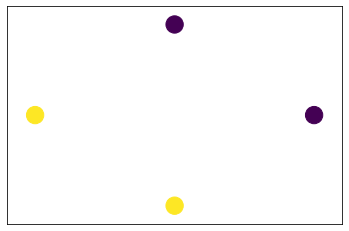

In [2]:
positions = [[0,1], [1, 0], [0,-1],[-1, 0]]
guess = [0, 0, 1, 1]

nodes_0 = [NodeWithPos(g, *pos) for g, pos in zip(guess, positions)]
graph_0 = nx.Graph()
graph_0.add_nodes_from(nodes_0)
draw_graph(graph_0)


The edges in a MRF represents a potential defined by some potential function, taking the nodes of the edge as arguments. Higher potential (thicker line) corresponds to a higher partial probability.

(This is a simplification that is true for this graph, bur not every graph. For more info read about cliques [here](https://ermongroup.github.io/cs228-notes/representation/undirected/).)

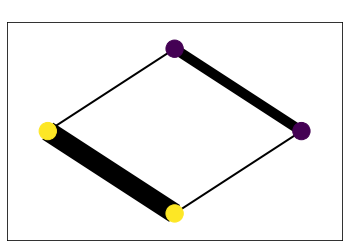

In [3]:
def neighour_potential(x: NodeWithPos, y: NodeWithPos):
    if x.value == y.value == 1:
        return 10
    elif x.value == y.value == 0:
        return 5
    else:
        return 1
    
for i in range(4):
    x, y = nodes_0[i], nodes_0[(i+1) % 4]
    graph_0.add_edge(x, y, capacity=neighour_potential(x, y))
draw_graph(graph_0, "Guessed graph")


The score  of a graph with some configuration of nodes is then equal to the product of energies (edges) in the graph.

In [4]:
def get_potentials(graph):
    return [edge[2]['capacity'] for edge in graph.edges(data=True)]
    
def get_score(graph):
    return np.prod(get_potentials(graph))

score_0 = get_score(graph_0)
print( "The score of the the guessed graph is "
       f"{'*'.join([str(i) for i in get_potentials(graph_0)])}={score_0}")


The score of the the guessed graph is 5*1*1*10=50


To find the probability of a given configuration, one multiplies by 1 devide by the sum of the scores all the different possible configurations. 

This can be hard, or even impossible, to calculate. Even with nodes with a binary state, the number of configurations is equal to $2^n$ where $n$ is the number of nodes. Nodes can also represent continuous states will require the use of integrals. 

In [5]:
scores = []
graphs = []
for guess in product(*[[0, 1]]*4):
    nodes = [NodeWithPos(g, *pos) for g, pos in zip(guess, positions)]
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    for i in range(4):
        x, y = nodes[i], nodes[(i+1) % 4]
        graph.add_edge(x, y, capacity=neighour_potential(x, y))
    scores.append(get_score(graph))
    graphs.append(graph)    

print(f"The probability of initial graph is "
      f"{score_0}*(1/{sum(scores)})={score_0/sum(scores)}")


The probability of initial graph is 50*(1/11327)=0.004414231482298932


There are many different ways to find the most likely configuration, but one trivial way is to just try them all as we did above.

As the probability is the score multiplied by a constant, finding the configuration with the highest probability is the same as finding the configuration with the highes score.

The probability of the best graph is 0.8828462964597864
The probability of the worst graph is 8.828462964597864e-05


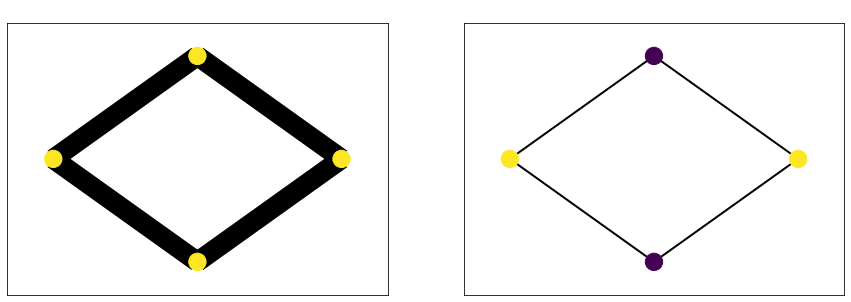

In [6]:
best_idx = np.argmax(scores)
best_score = scores[best_idx]
best_graph = graphs[best_idx]

worst_idx = np.argmin(scores)
worst_score = scores[worst_idx]
worst_graph = graphs[worst_idx]

print( f"The probability of the best graph is {best_score/sum(scores)}")
print(f"The probability of the worst graph is {worst_score/sum(scores)}")

fic, axs = plt.subplots(1,2, figsize=(15,5))
draw_graph(best_graph, "Best graph", axs[0])
draw_graph(worst_graph, "Worst graph", axs[1])


One important thing to note is that it is often very usefull to work with the logarithm of the energies, so that the score can be calculated from a sum instead of a product. As the $log$ function is monotone, finding the graph with the highest score also has the highest sum of log energies. To keep the notation short we abbreviate `log_potential` as `lpot`.

get_score(graph_0)=50, get_score_from_log(graph_log)=50.00


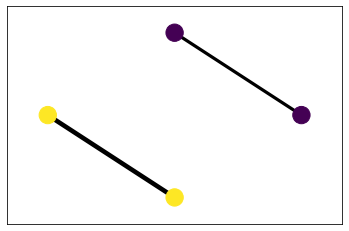

In [7]:
def neighbor_lpot(x, y):
    return np.log(neighour_potential(x, y))

graph_log = nx.Graph()
graph_log.add_nodes_from(nodes_0)
for i in range(4):
    x, y = nodes_0[i], nodes_0[(i+1) % 4]
    graph_log.add_edge(x, y, capacity=neighbor_lpot(x, y))
    
draw_graph(graph_log)

def get_score_from_log(graph):
    return np.exp(np.sum(get_potentials(graph)))
print(f"{get_score(graph_0)=}, {get_score_from_log(graph_log)=:.2f}")

Finally, it is often normal to use potential functions of the form $\exp(f(x,y,...))$, so that the log potential is easy to work with: $f(x,y,...)$.

In [8]:
def square_error_lpot(x, y, scale):
    scale*(x-y)**2
    
def square_error_potential(x, y, scale): # We dont really care about this
    return np.exp(square_error_lpot(x, y, scale))
